In [ ]:
import numpy as np
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models import DiodeModel
from src.extraction import ModelExtractor
from src.visualization import plot_diode_fit, diode_error_plot

from scipy.constants import k as k_B, e as q_e
import matplotlib.pyplot as plt


## Single Temperature Fit Demo

True parameters: {'I_s': 1e-10, 'n': 1.5, 'R_s': 2.5}
Fitted parameters: {'I_s': np.float64(9.945024986435832e-11), 'n': np.float64(1.500233992731446), 'R_s': np.float64(2.460019472653446)}
RMS err: 0.01954930159313382


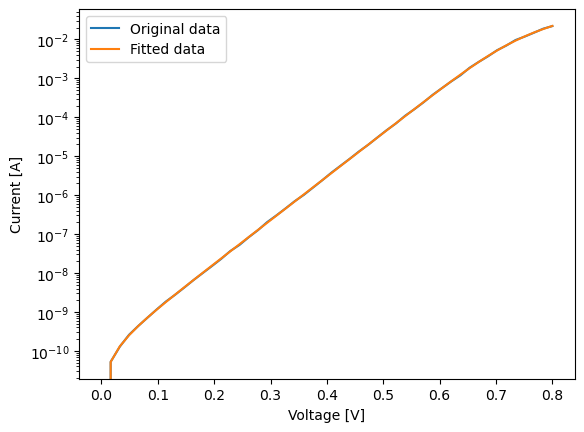

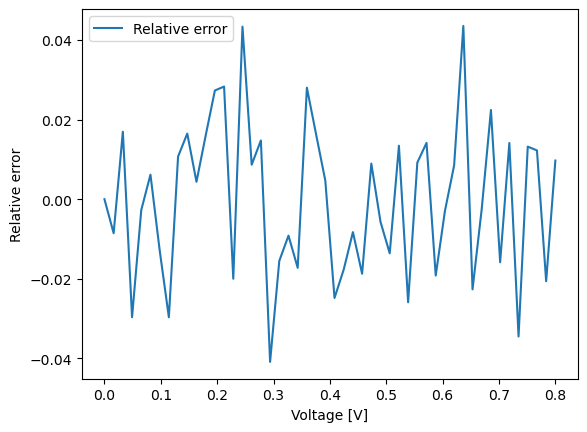

In [ ]:
model = DiodeModel()
extractor = ModelExtractor(model)

true_params = {
    'I_s': 1e-10, 
    'n': 1.5, 
    'R_s': 2.5
}

T_test = 300
V_data = np.linspace(0, 0.8, 50)
I_true = model.compute_current(V_data, true_params, T=T_test)

np.random.seed(67)
I_noise = I_true * (1 + np.random.normal(0, 0.02, size=I_true.shape))

initial_guess = {'I_s': 1e-11, 'n': 1.4, 'R_s': 0.1}
report = extractor.diode_fit(V_data, I_noise, T=T_test, initial_params=initial_guess)

print("True parameters:", true_params)
print("Fitted parameters:", report['parameters'])
print("RMS err:", report['rms_err'])

plot_diode_fit(V_data, I_noise, model, report['parameters'])
diode_error_plot(V_data, I_noise, model, report['parameters'])

## Multi-Temperature Fit Demo

True global: {'I_s': 1e-10, 'Eg': 1.12, 'n': 1.5, 'R_s': 2.5}
Fitted global: {'I_s': np.float64(9.936082802953109e-11), 'Eg': np.float64(1.1212797290721794), 'n': np.float64(1.4993509574423012), 'R_s': np.float64(2.5064261432634534)}
Global RMS err: 0.01955007647085956


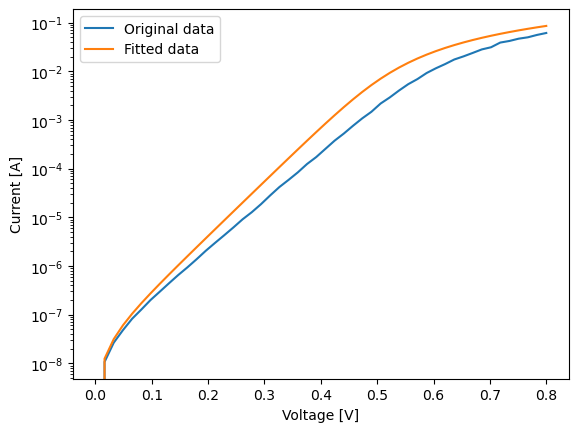

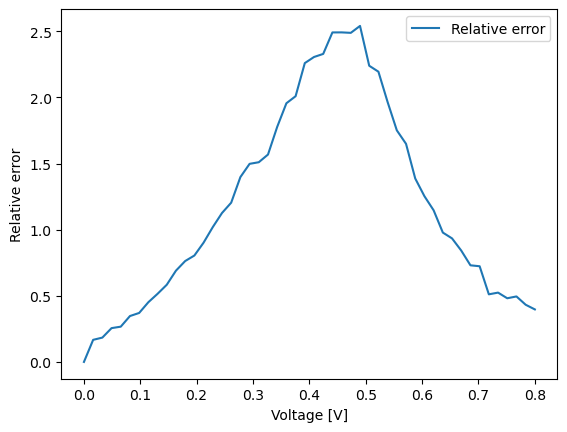

In [ ]:
T_ref = 300
true_global = {
    'I_s': 1e-10, 
    'Eg': 1.12, 
    'n': 1.5, 
    'R_s': 2.5
}

def Is_at_T(T):
    Is_ref = true_global['I_s']
    Eg = true_global['Eg']
    return Is_ref * (T / T_ref)**3 * np.exp(((Eg * q_e) / k_B) * (1/T_ref - 1/T))

temps = [280, 300, 320, 340]
V_sweep = np.linspace(0, 0.8, 50)

datasets = []
np.random.seed(41)

for T in temps:
    Is_local = Is_at_T(T)
    local_params = {
        'I_s': Is_local,
        'n': true_global['n'],
        'R_s': true_global['R_s']
    }
    I_ideal = model.compute_current(V_sweep, local_params, T=T)
    I_noise = I_ideal * (1 + np.random.normal(0, 0.02, size=I_ideal.shape))
    datasets.append((V_sweep, I_noise, T))
    
initial_global = {
    'I_s': 1e-11,
    'Eg': 1.0,
    'n': 1.2,
    'R_s': 0.1
}

report = extractor.diode_temp_fit(datasets, initial_params=initial_global)
fit_global = report['parameters']

print('True global:', true_global)
print('Fitted global:', fit_global)
print('Global RMS err:', report['rms_err'])

Is_ref_fit = fit_global['I_s']
Eg_fit = fit_global['Eg']

def Is_at_T_fit(T):
    return Is_ref_fit * (T / T_ref)**3 * np.exp((Eg_fit * q_e / k_B) * (1/T_ref - 1/T))

for V, I_measured, T in datasets:
    local_params = {
        'I_s': Is_at_T_fit(T),
        'n': fit_global['n'],
        'R_s': fit_global['R_s']
    }
    
plot_diode_fit(V, I_measured, model, local_params)
diode_error_plot(V, I_measured, model, local_params)

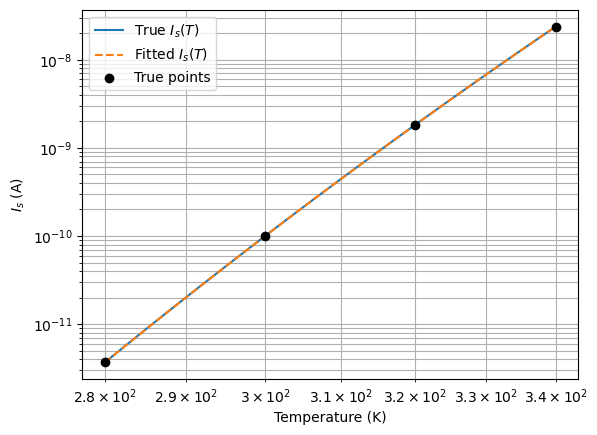

In [5]:
# Plot Is(T)

T_plot = np.linspace(min(temps), max(temps), 100)
Is_true_curve = [Is_at_T(T) for T in T_plot]
Is_fit_curve = [Is_at_T_fit(T) for T in T_plot]

plt.figure()
plt.loglog(T_plot, Is_true_curve, label="True $I_s(T)$")
plt.loglog(T_plot, Is_fit_curve, "--", label="Fitted $I_s(T)$")
plt.scatter(temps, [Is_at_T(T) for T in temps], color="k", zorder=3, label="True points")
plt.xlabel("Temperature (K)")
plt.ylabel("$I_s$ (A)")
plt.legend()
plt.grid(True, which="both")
plt.show()